### Build a simple econometric model and evaluate its preformance

Task: Take a simple econometric model and implement it. But the model is not the main thing here. What’s more important is the testing procedure step-by-step.
- What should we do to evaluate a simple algorithm that gives out buy and sell signal?
- What should we program and do to evaluate such an algotythm?
- What leverage should we use?
- Build it based on S&P500. And perhaps compare to other benchmarks.
- Take two or more models and compare them.
- Use the paper “INVESTMENT STRTEGIES THAT BEAT THE MARKET. WHAT CAN WE SQUEEZE FROM THE MARKET?”
- Describe results and provide visualizations.


###### 04.04.19

#### Data gathering

In [2]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats

In [3]:
# First, downloading the data
ticker = '^GSPC'

# Setting time horizon of data
start_date = '2010-01-01'
end_date = '2019-04-04'

# Downloading the data using pandas_reader.data.DataReader
panel_data = data.DataReader(ticker, 'yahoo', start_date, end_date)

In [4]:
# Basic statistics for the downloaded data
panel_data.describe()

,High,Low,Open,Close,Volume,Adj Close
count,2329.000000,2329.000000,2329.000000,2329.000000,2.329000e+03,2329.000000
mean,1889.747797,1870.972632,1880.714894,1881.162112,3.734552e+09,1881.162112
std,534.620409,532.229691,533.539543,533.356348,8.252354e+08,533.356348
min,1032.949951,1010.909973,1027.650024,1022.580017,1.025000e+09,1022.580017
25%,1363.459961,1348.339966,1358.040039,1357.989990,3.247710e+09,1357.989990
50%,1943.689941,1918.599976,1931.869995,1931.589966,3.612810e+09,1931.589966
75%,2251.689941,2233.620117,2241.129883,2241.350098,4.099600e+09,2241.350098
max,2940.909912,2927.110107,2936.760010,2930.750000,1.061781e+10,2930.750000


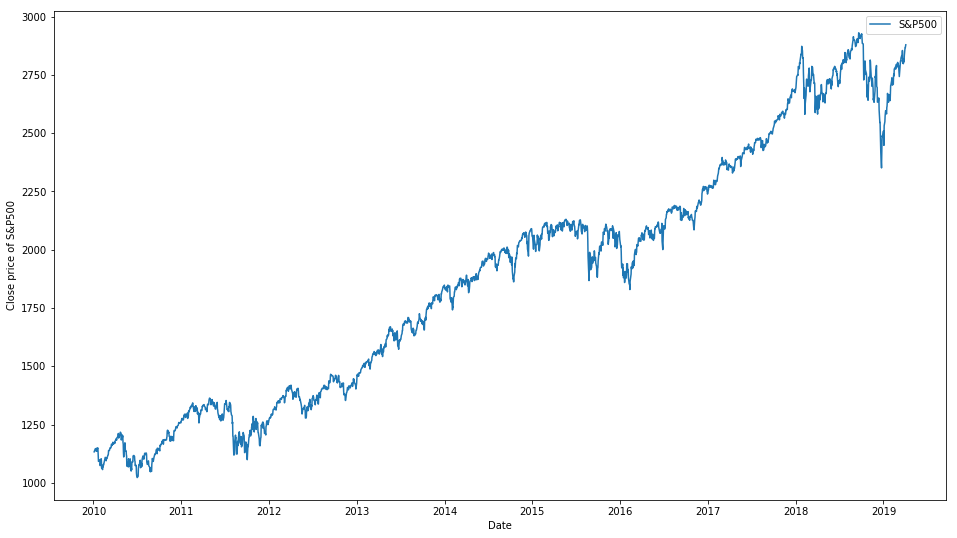

In [5]:
# Graph for data

fig, ax = plt.subplots(figsize=(16,9))
ax.plot(panel_data.index, panel_data.Close, label='S&P500')

ax.set_xlabel('Date')
ax.set_ylabel('Close price of S&P500')
ax.legend()

#### Building a simple strategy

In [6]:
# At first let's go really simple and go with a "Golden Cross strategy"

'''
The Golden Cross is a bullish phenomenon when the 50-day moving average 
crosses above the 200-day moving average.

We'll also see the below crossing as a selling signal.

Yet we only need a signal generating sistem, so it will do.
'''

def GoldenCross(series, ma1, ma2):
    '''
    Takes the whole time series as a pandas dataframe, windows for 1st and 2nd simple MAs.
    MA1 window is smaller than MA2 window.
    Outputs pandas dataframe with addeed column for signals:
    +1 - for buy
    0  - no signal
    -1 - for sell
    Signals calculated based on "Close" column.
    '''
    series['ma1'] = series.Close.rolling(window=ma1).mean()
    series['ma2'] = series.Close.rolling(window=ma2).mean()

    conditions = [
    (pd.isna(series['ma1'])) | (pd.isna(series['ma2'])),
    (series['ma1'] >= series['ma2']),
    (series['ma1'] < series['ma2'])]
    choices = [0, 1, -1]
    
    series['Signal'] = np.select(conditions, choices)
    
    return series
    

In [7]:
# Applying it

panel_data = GoldenCross(panel_data, 50,200)

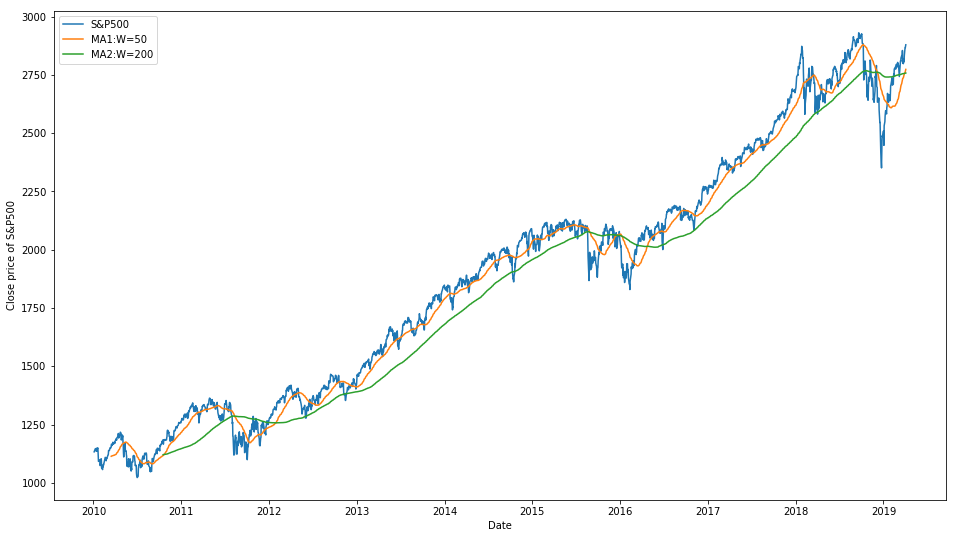

In [8]:
# Visualizintg the two MAs

fig, ax = plt.subplots(figsize=(16,9))
ax.plot(panel_data.index, panel_data.Close, label='S&P500')
ax.plot(panel_data.index, panel_data.ma1, label='MA1:W=50')
ax.plot(panel_data.index, panel_data.ma2, label='MA2:W=200')

ax.set_xlabel('Date')
ax.set_ylabel('Close price of S&P500')
ax.legend()

In [9]:
# Watching statisstics for the signal created

panel_data.groupby('Signal').count()

,High,Low,Open,Close,Volume,Adj Close,ma1,ma2
Signal,,,,,,,,
-1,349,349,349,349,349,349,349,349
0,199,199,199,199,199,199,150,0
1,1781,1781,1781,1781,1781,1781,1781,1781


We now have a simple signal generated.

It's a signal for a long timeframe trading, as the MA values are relatively big. 

The signals are imbalaced towards buying signals in a relation of aproximately 5:1.

#### Model evaluation

Statistics to implement and calculate:
- aSD
- 5%-VaR
- maxFL
- MD
- AMD
- MLD
- Correlation
- AllRisk
- ARC
- Sharpe
- IR
- ARC/MD
- ARC/AMD



In [52]:
# First, calculating the returns on a stragegy.
# Taking the results for the last year: 04.04.18 - 04.04.19

'''
Yet implementing a simplified model, in whitch we can go long or short in the beginning of the day with 
an open price and close it with the close price. 
The direction of trade is chosen using a signal provided.
'''

def CalculateReturns(series, start, finish):
    '''
    Takes the whole time series as a pandas dataframe, time of start and end of calculation of returns.
    MA1 window is smaller than MA2 window.
    Outputs pandas dataframe with addeed column for Returns in %:
    Returns calculated based on "Open", "Close" and "Signal" columns.
    Also outputs log returns.
    '''
    interval = series[start:finish]
    
    interval['Return'] = (interval['Close']-interval['Open'])/interval['Open']*interval['Signal']*100
    
    # Log Returns
    interval['Logreturn'] = (np.log(interval['Close']/interval['Open'])*100).where(interval['Signal'] == 1, np.log(interval['Open']/interval['Close'])*100)
    
    return interval

In [53]:
# Looking at the signals during three last years:

panel_data['2016-04-04':'2019-04-04'].groupby('Signal').count()

,High,Low,Open,Close,Volume,Adj Close,ma1,ma2
Signal,,,,,,,,
-1,92,92,92,92,92,92,92,92
1,665,665,665,665,665,665,665,665


A little more balanced over the last year

In [54]:
interval = CalculateReturns(panel_data, '2016-04-04', '2019-04-04')

# Looking at the statistics of calculated Returns

interval['Return'].describe()

D:\programs\Anaconda\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\programs\Anaconda\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


count    757.000000
mean       0.003077
std        0.683816
min       -4.425498
25%       -0.236072
50%        0.015125
75%        0.298134
max        3.073293
Name: Return, dtype: float64

The average return is slightly positive

In [55]:
# Looking at the statistics of calculated Logreturns

interval['Logreturn'].describe()

count    757.000000
mean       0.001778
std        0.685095
min       -4.330369
25%       -0.236351
50%        0.015124
75%        0.297691
max        3.027014
Name: Logreturn, dtype: float64

The results are simmilar

In [56]:
# aSD

def calc_aSD(series, log = False):
    '''
    Calculates the Annual Standard Deviation. 
    Takes pandas dataframe with a column 'Return' as an input.
    By default calculates simple, can also do logarithmic.
    '''
    if log:
        series['logretavg'] = series['Logreturn'] - series['Logreturn'].mean()
        res = (252 ** (1/2)) * (1/(series.size - 1) * 
                                sum ((series['logretavg']) ** (2)))
    else:
        series['retavg'] = series['Return'] - series['Return'].mean()
        res = (252 ** (1/2)) * (1/(series.size - 1) * 
                                sum ((series['retavg']) ** (2)))
    
    return res


In [57]:
aSD = calc_aSD(interval, True)

print(aSD)

0.6201471498722766


D:\programs\Anaconda\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [60]:
# 5%-VaR

def calc_5VaR(series):
    '''
    Calculates the 5% Value at Risk. 
    Takes pandas dataframe with a column 'Return' as an input.
    Calculated on the basis of historical daily returns.
    
    Also produces a histogram for returns.
    '''
    mean = np.mean(series['Return'])
    std = np.std(series['Return']) 
    
    # Plotting
    interval['Return'].hist(bins = 30, density = True )
    x = np.linspace(mean - 3*std, mean + 3*std, 100)
    pdf = stats.norm.pdf(x, mean, std)
    plt.plot(x, pdf, label = "Overlayed normal")
       
    res = -stats.norm.ppf(0.05, mean, std)
        
    return res

1.1209576141415944

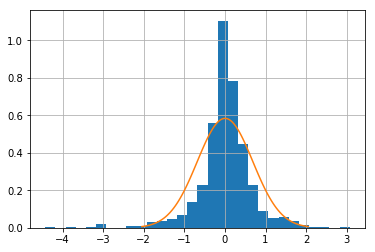

In [61]:
calc_5VaR(interval)

In [36]:
# maxFL

'''
As is not implemented in the strategy, yet the test is unused
'''

'\nAs is not implemented in the strategy, yet the test is unused\n'

In [37]:
# Creating the balance column for next statistics
'''
interval['Balance'] = 0
#interval.loc[0, 'Balance'] = 1
for index, row in interval.iterrows():
    interval.loc[i, 'Balance'] = interval.loc[i-1, 'Balance'] * interval.loc[i, 'Return']

for i in range(1, len(interval)):
    interval.loc[i, 'Balance'] = interval.loc[i-1, 'Balance'] * interval.loc[i, 'Return']
'''

"\ninterval['Balance'] = 0\n#interval.loc[0, 'Balance'] = 1\nfor index, row in interval.iterrows():\n    interval.loc[i, 'Balance'] = interval.loc[i-1, 'Balance'] * interval.loc[i, 'Return']\n\nfor i in range(1, len(interval)):\n    interval.loc[i, 'Balance'] = interval.loc[i-1, 'Balance'] * interval.loc[i, 'Return']\n"

In [62]:
# MD

# TODO: calculate based on balance change and not the value of initial instrument
# TODO: do as logarythmic
def calc_MD(series, window = 252):
    '''
    Calculates the 5% Value at Risk. 
    Takes pandas dataframe with a column 'Return' as an input.
    Also takes the window for drawdawn calculation. Default value is 252
    
    Calculating using formulae ( Close.max() - Close.min() ) / Close.max()
    Outputs the plot.
    '''

    # Calculating first the maximum rolling value for the Close price
    # Then calculating daily drowdown
    Roll_Max = series['Close'].rolling(window, min_periods=1).max()
    Daily_Drawdown = series['Close']/Roll_Max - 1
    
    # Finally, getting the maximum drowdown with respect to window 
    Max_Daily_Drawdown = Daily_Drawdown.rolling(window, min_periods=1).min()

    # Plot the results
    Daily_Drawdown.plot()
    Max_Daily_Drawdown.plot()
    
    return Max_Daily_Drawdown.min()

-0.19778210435681998

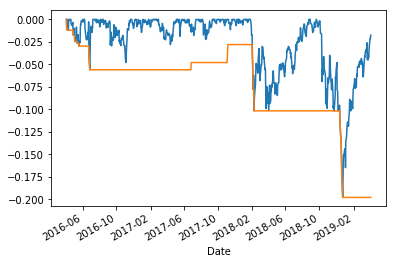

In [63]:
calc_MD(interval)

In [64]:
# AMD

'''
Currently not implemented as we have only a year of testing, not multiple
'''

calc_AMD = calc_MD

In [65]:
# MLD

'''
Yet not done as only have a year in observation
'''

'\nYet not done as only have a year in observation\n'

In [66]:
# AllRisk

'''
Aggregated measurement that is done using formula AllRisk = aSD*MD*MLD*AMD*1000 
'''

def calc_AllRisk(series):
    '''
    Takes pandas dataframe as an input.
    AllRisk = aSD*MD*MLD*AMD*1000 
    '''
    
    res = calc_aSD(series)*calc_MD(series)*calc_MLD(series)*calc_AMD(series)*1000 
    
    return res

In [76]:
# ARC

def calc_ARC(series):
    '''
    Takes the pandas dataframe and calculates the Annual Return Compounded.
    '''
    
    res = 252 * 1/len(series) * series['Logreturn'].sum()
    
    return res   
    

In [77]:
calc_ARC(interval)

0.44815956271613366

In [69]:
# Sharpe

def calc_Sharpe(series, no_risk_return = 0):
    '''
    Calculates Sharpe ratio given pandas dataframe with 'Return' column.
    Also requires safe return rate.
    '''
    res = (252 ** 0.5) * (series['Return'].mean() - no_risk_return) / series['Return'].std()    
        
    return res


In [70]:
calc_Sharpe(interval)

0.07142822021699971

In [71]:
# IR

def calc_IR(series):
    '''
    Calculates IR. Requires pandas dataframe.
    '''
    res = calc_ARC(series)/calc_aSD(series)
        
    return res

In [72]:
calc_IR(interval)

D:\programs\Anaconda\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


1.3595766962660638

In [73]:
# ARC/MD

def calc_ARCMD(series):
    '''
    Calculates ARC/MD
    '''
    res = calc_ARC(series)/calc_MD(series)
    
    return res

-3.920329095454525

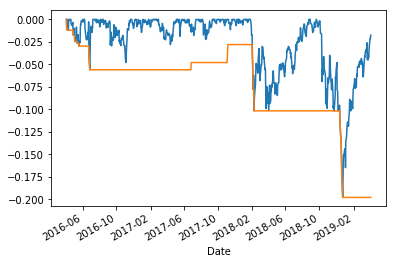

In [74]:
calc_ARCMD(interval)

In [75]:
# ARC/AMD

def calc_ARCAMD(series):
    '''
    Calculates ARC/AMD
    '''
    res = calc_ARC(series)/calc_AMD(series)
    
    return res